In [1]:
import jax
from jax import random
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# Make sure tf does not allocate gpu memory.
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
class Encoder(nn.Module):
  latents: int

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(500, name='fc1')(x)
    x = nn.relu(x)
    mean_x = nn.Dense(self.latents, name='fc2_mean')(x)
    logvar_x = nn.Dense(self.latents, name='fc2_logvar')(x)
    return mean_x, logvar_x

In [4]:
class Decoder(nn.Module):

  @nn.compact
  def __call__(self, z):
    z = nn.Dense(500, name='fc1')(z)
    z = nn.relu(z)
    z = nn.Dense(784, name='fc2')(z)
    return z

In [5]:
class VAE(nn.Module):
  latents: int = 20

  def setup(self):
    self.encoder = Encoder(self.latents)
    self.decoder = Decoder()

  def __call__(self, x, z_rng):
    mean, logvar = self.encoder(x)
    z = reparameterize(z_rng, mean, logvar)
    recon_x = self.decoder(z)
    return recon_x, mean, logvar

  def generate(self, z):
    return nn.sigmoid(self.decoder(z))

In [6]:
def reparameterize(rng, mean, logvar):
  std = jnp.exp(0.5 * logvar)
  eps = random.normal(rng, logvar.shape)
  return mean + eps * std

In [7]:
@jax.vmap
def kl_divergence(mean, logvar):
  return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

In [8]:
@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
  logits = nn.log_sigmoid(logits)
  return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))

In [9]:
def compute_metrics(recon_x, x, mean, logvar):
  bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
  kld_loss = kl_divergence(mean, logvar).mean()
  return {
      'bce': bce_loss,
      'kld': kld_loss,
      'loss': bce_loss + kld_loss
  }

In [10]:
# The dimension of latent space
latents = 20

In [11]:
def model():
  return VAE(latents)

In [12]:
@jax.jit
def train_step(state, batch, z_rng):
  def loss_fn(params):
    recon_x, mean, logvar = model().apply({'params': params}, batch, z_rng)

    bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    loss = bce_loss + kld_loss
    return loss
  grads = jax.grad(loss_fn)(state.params)
  return state.apply_gradients(grads=grads)

In [13]:
@jax.jit
def eval(params, images, z, z_rng):
  def eval_model(vae):
    recon_images, mean, logvar = vae(images, z_rng)
    comparison = jnp.concatenate([images[:8].reshape(-1, 28, 28, 1),
                                  recon_images[:8].reshape(-1, 28, 28, 1)])

    generate_images = vae.generate(z)
    generate_images = generate_images.reshape(-1, 28, 28, 1)
    metrics = compute_metrics(recon_images, images, mean, logvar)
    return metrics, comparison, generate_images

  return nn.apply(eval_model, model())({'params': params})

In [14]:
def prepare_image(x):
  x = tf.cast(x['image'], tf.float32)
  x = tf.reshape(x, (-1,))
  return x

In [15]:
rng = random.PRNGKey(42)
rng, key = random.split(rng)

batch_size = 128

In [16]:
ds_builder = tfds.builder('binarized_mnist')
ds_builder.download_and_prepare()
train_ds = ds_builder.as_dataset(split=tfds.Split.TRAIN)
train_ds = train_ds.map(prepare_image)
train_ds = train_ds.cache()
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(50000)
train_ds = train_ds.batch(batch_size)
train_ds = iter(tfds.as_numpy(train_ds))

In [17]:
test_ds = ds_builder.as_dataset(split=tfds.Split.TEST)
test_ds = test_ds.map(prepare_image).batch(10000)
test_ds = np.array(list(test_ds)[0])
test_ds = jax.device_put(test_ds)

In [18]:
init_data = jnp.ones((batch_size, 784), jnp.float32)

learning_rate = 0.001

In [19]:
state = train_state.TrainState.create(
      apply_fn=model().apply,
      params=model().init(key, init_data, rng)['params'],
      tx=optax.adam(learning_rate),
  )

In [20]:
rng, z_key, eval_rng = random.split(rng, 3)
z = random.normal(z_key, (64, latents))

In [21]:
steps_per_epoch = 50000 // batch_size

num_epochs = 50000 // batch_size

In [22]:
for epoch in range(num_epochs):
    for _ in range(steps_per_epoch):
      batch = next(train_ds)
      rng, key = random.split(rng)
      state = train_step(state, batch, key)

    metrics, comparison, sample = eval(state.params, test_ds, z, eval_rng)
    
    print('eval epoch: {}, loss: {:.4f}, BCE: {:.4f}, KLD: {:.4f}'.format(
        epoch + 1, metrics['loss'], metrics['bce'], metrics['kld']))

eval epoch: 1, loss: 120.1392, BCE: 95.7033, KLD: 24.4359
eval epoch: 2, loss: 112.2488, BCE: 86.9650, KLD: 25.2838
eval epoch: 3, loss: 109.2422, BCE: 82.8458, KLD: 26.3964
eval epoch: 4, loss: 107.4002, BCE: 80.3923, KLD: 27.0080
eval epoch: 5, loss: 106.2178, BCE: 79.5005, KLD: 26.7173
eval epoch: 6, loss: 105.3602, BCE: 79.3021, KLD: 26.0581
eval epoch: 7, loss: 104.7277, BCE: 78.3925, KLD: 26.3352
eval epoch: 8, loss: 104.2670, BCE: 77.7459, KLD: 26.5211
eval epoch: 9, loss: 103.8640, BCE: 77.1686, KLD: 26.6954
eval epoch: 10, loss: 103.6325, BCE: 76.1688, KLD: 27.4637
eval epoch: 11, loss: 103.0272, BCE: 75.9591, KLD: 27.0681
eval epoch: 12, loss: 102.7671, BCE: 75.7722, KLD: 26.9949
eval epoch: 13, loss: 102.7235, BCE: 75.1008, KLD: 27.6227
eval epoch: 14, loss: 102.6699, BCE: 74.9213, KLD: 27.7486
eval epoch: 15, loss: 102.2030, BCE: 75.1462, KLD: 27.0567
eval epoch: 16, loss: 102.2237, BCE: 75.0130, KLD: 27.2107
eval epoch: 17, loss: 101.9821, BCE: 74.5164, KLD: 27.4657
eval e

eval epoch: 141, loss: 99.2212, BCE: 71.1911, KLD: 28.0301
eval epoch: 142, loss: 99.2329, BCE: 71.1313, KLD: 28.1016
eval epoch: 143, loss: 99.2584, BCE: 70.9431, KLD: 28.3153
eval epoch: 144, loss: 99.4919, BCE: 71.3096, KLD: 28.1823
eval epoch: 145, loss: 99.0851, BCE: 71.3507, KLD: 27.7344
eval epoch: 146, loss: 99.1800, BCE: 71.4469, KLD: 27.7331
eval epoch: 147, loss: 99.2798, BCE: 71.3593, KLD: 27.9205
eval epoch: 148, loss: 99.4056, BCE: 71.4552, KLD: 27.9505
eval epoch: 149, loss: 99.4620, BCE: 71.4044, KLD: 28.0576
eval epoch: 150, loss: 99.3495, BCE: 71.1057, KLD: 28.2438
eval epoch: 151, loss: 99.2337, BCE: 71.3616, KLD: 27.8720
eval epoch: 152, loss: 99.1738, BCE: 71.1856, KLD: 27.9883
eval epoch: 153, loss: 99.1963, BCE: 70.7222, KLD: 28.4741
eval epoch: 154, loss: 99.2326, BCE: 71.3934, KLD: 27.8392
eval epoch: 155, loss: 99.2400, BCE: 71.5039, KLD: 27.7361
eval epoch: 156, loss: 99.4303, BCE: 71.2249, KLD: 28.2054
eval epoch: 157, loss: 99.2224, BCE: 70.9735, KLD: 28.24

eval epoch: 281, loss: 99.3570, BCE: 71.6665, KLD: 27.6904
eval epoch: 282, loss: 99.5422, BCE: 71.3933, KLD: 28.1489
eval epoch: 283, loss: 99.4824, BCE: 71.0251, KLD: 28.4573
eval epoch: 284, loss: 99.4538, BCE: 71.7573, KLD: 27.6965
eval epoch: 285, loss: 99.3569, BCE: 71.1964, KLD: 28.1606
eval epoch: 286, loss: 99.4018, BCE: 71.4751, KLD: 27.9267
eval epoch: 287, loss: 99.5983, BCE: 71.5953, KLD: 28.0029
eval epoch: 288, loss: 99.5618, BCE: 71.1998, KLD: 28.3620
eval epoch: 289, loss: 99.2294, BCE: 70.7388, KLD: 28.4907
eval epoch: 290, loss: 99.3261, BCE: 71.5003, KLD: 27.8259
eval epoch: 291, loss: 99.4319, BCE: 71.2664, KLD: 28.1655
eval epoch: 292, loss: 99.4181, BCE: 71.4966, KLD: 27.9216
eval epoch: 293, loss: 99.4448, BCE: 70.9375, KLD: 28.5073
eval epoch: 294, loss: 99.3534, BCE: 71.0520, KLD: 28.3015
eval epoch: 295, loss: 99.5125, BCE: 71.3951, KLD: 28.1174
eval epoch: 296, loss: 99.4032, BCE: 71.4468, KLD: 27.9565
eval epoch: 297, loss: 99.4393, BCE: 71.3685, KLD: 28.07

In [23]:
# Let's visualise the reconstruction from the last epoch
import math
from PIL import Image

In [24]:
def display_image(ndarray, fp, nrow=8, padding=2, pad_value=0.0, format=None):
    """Make a grid of images.
  Args:
    ndarray (array_like): 4D mini-batch images of shape (B x H x W x C)
    fp - A filename(string) or file object
    nrow (int, optional): Number of images displayed in each row of the grid.
      The final grid size is ``(B / nrow, nrow)``. Default: ``8``.
    padding (int, optional): amount of padding. Default: ``2``.
    scale_each (bool, optional): If ``True``, scale each image in the batch of
      images separately rather than the (min, max) over all images. Default: ``False``.
    pad_value (float, optional): Value for the padded pixels. Default: ``0``.
    format(Optional):  If omitted, the format to use is determined from the filename extension.
      If a file object was used instead of a filename, this parameter should always be used.
  """
    if not (isinstance(ndarray, jnp.ndarray) or
        (isinstance(ndarray, list) and all(isinstance(t, jnp.ndarray) for t in ndarray))):
        raise TypeError(f'array_like of tensors expected, got {type(ndarray)}')

    ndarray = jnp.asarray(ndarray)

    if ndarray.ndim == 4 and ndarray.shape[-1] == 1:  # single-channel images
        ndarray = jnp.concatenate((ndarray, ndarray, ndarray), -1)

    # make the mini-batch of images into a grid
    nmaps = ndarray.shape[0]
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(ndarray.shape[1] + padding), int(ndarray.shape[2] + padding)
    num_channels = ndarray.shape[3]
    grid = jnp.full((height * ymaps + padding, width * xmaps + padding, num_channels), pad_value).astype(jnp.float32)
    k = 0
    for y in range(ymaps):
      for x in range(xmaps):
        if k >= nmaps:
          break
        grid = grid.at[y * height + padding:(y + 1) * height,
                       x * width + padding:(x + 1) * width].set(ndarray[k])
        k = k + 1

    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = np.array(jnp.clip(grid * 255.0 + 0.5, 0, 255).astype(jnp.uint8))
    im = Image.fromarray(ndarr.copy())
    display(im)


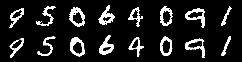

In [25]:
display_image(comparison, f'results/reconstruction_{epoch}.png', nrow=8)

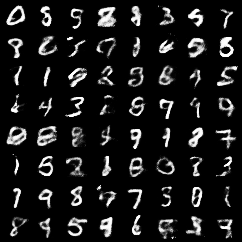

In [26]:
display_image(sample, f'results/sample_{epoch}.png', nrow=8)